In [1]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit

sys.path.insert(0, './radiometric')
from LUT_functions import pixel_registration, create_LUT_df
import scipy

# Seaborn for plotting and styling
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid", {'axes.grid' : False})

In [3]:
#choose filepath to desired data
path = '/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_data/BBpolarized/'
cal_file1 =  "/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_files/cam1pixel.h5"
cal_file2 =  "/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_files/cam2pixel.h5"

In [4]:
#will create a df and print the names of the keys in the original hdf5 file
df1 = create_LUT_df(path,'cam1_0deg.h5')
df2 = create_LUT_df(path,'cam2_0deg.h5')

In [5]:
waves= np.linspace(7,12,61)
lps = [0,10,20,30,40,50,60,70,80,90,110,130,150,170]
angles = np.round(np.linspace(-7.07,7.07,35),1)

In [6]:
#import nuc calibration
sys.path.insert(0, './NUC')
from NUC_functions import import_NUC, apply_NUC
cal_path = '/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_files/NUC.h5'

m1,b1,T_ref1,m2,b2,T_ref2 = import_NUC(cal_path)

In [7]:
#apply pixel registration and NUC to full dataset

ymin1 = 105; ymax1 = 140;
ymin2 = 130; ymax2 = 165;

mean_ims1 =[]
mean_ims2 =[]
std_ims1  =[]
std_ims2  =[]

mean_ims1n =[]
mean_ims2n =[]
std_ims1n  =[]
std_ims2n  =[]

for i in lps:
    #will create a df and print the names of the keys in the original hdf5 file
    df1 = create_LUT_df(path,'cam1_'+str(i)+'deg.h5')
    df2 = create_LUT_df(path,'cam2_'+str(i)+'deg.h5')
    
    corrected_images1= [] ; corrected_images1n= [];
    corrected_images2= [] ; corrected_images2n= []

    for i in range(len(df1)):
        #first without NUC correction
        r = df1['images1'][i];
        c = pixel_registration(r,cal_file1,waves,ymin1,ymax1)
        
        #now with NUC correction
        T = df1['temp1'][i];
        rn = apply_NUC(r,T,m1,b1,T_ref1)
        cn = pixel_registration(rn,cal_file1,waves,ymin1,ymax1)
        
        corrected_images1.append(c)
        corrected_images1n.append(cn)

    for i in range(len(df2)):
        #first without NUC correction
        r = df2['images1'][i];
        c = pixel_registration(r,cal_file2,waves,ymin2,ymax2)
        
        #now with NUC correction
        T = df2['temp1'][i];
        rn = apply_NUC(r,T,m2,b2,T_ref2)
        cn = pixel_registration(rn,cal_file2,waves,ymin2,ymax2)
        
        corrected_images2.append(c)
        corrected_images2n.append(cn)

    mean_ims1.append(np.mean(corrected_images1,axis = 0))
    mean_ims1n.append(np.mean(corrected_images1n,axis = 0))
    mean_ims2.append(np.mean(corrected_images2,axis = 0))
    mean_ims2n.append(np.mean(corrected_images2n,axis = 0))


    std_ims1.append(np.std(corrected_images1,axis = 0))
    std_ims2.append(np.std(corrected_images2,axis = 0))
    std_ims1n.append(np.std(corrected_images1n,axis = 0))
    std_ims2n.append(np.std(corrected_images2n,axis = 0))

In [9]:
d = {'lps': lps, 'ims1': list(mean_ims1),'s1': list(std_ims1), 'ims2':list(mean_ims2),'s2': list(std_ims2)}
dn = {'lps': lps, 'ims1': list(mean_ims1n),'s1': list(std_ims1n), 'ims2':list(mean_ims2n),'s2': list(std_ims2n)}


In [10]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

dfn = pd.DataFrame.from_dict(dn, orient='index')
dfn = dfn.transpose()

dfn

,lps,ims1,s1,ims2,s2
0,0,"[[23026.854330353686, 23033.460759659847, 2304...","[[2.2303989602829404, 2.685945593641517, 1.657...","[[22487.542258331192, 22493.746684200833, 2249...","[[4.398206401020674, 3.5266980112629245, 3.639..."
1,10,"[[23034.823096117507, 23044.012564209956, 2305...","[[1.8501241799012127, 2.695888484453369, 2.391...","[[22495.636972449476, 22501.315688769, 22502.2...","[[4.757171125937215, 5.210141865977874, 5.3990..."
2,20,"[[23030.564572353145, 23037.91713302429, 23044...","[[1.52184465425815, 1.861779022575204, 1.26879...","[[22487.265360962832, 22493.515159914718, 2249...","[[4.9271994662980525, 4.025032761052026, 3.794..."
3,30,"[[23028.93609535835, 23036.346455534287, 23044...","[[1.5151353386361666, 2.0508542318854426, 1.54...","[[22480.30579795174, 22488.79087503733, 22486....","[[3.819254049383103, 3.756255213292122, 4.1453..."
4,40,"[[23029.661789045833, 23037.37862351923, 23046...","[[2.1298034897520677, 2.902873595654444, 1.858...","[[22496.192821785728, 22502.601409767765, 2250...","[[7.68712303671534, 6.713531942097864, 6.98512..."
5,50,"[[23031.320647551034, 23039.78085965795, 23047...","[[1.4488179984306377, 1.7919174879491908, 1.30...","[[22492.175888768714, 22497.77178652453, 22495...","[[5.7783820404498645, 4.754691757897911, 5.054..."
6,60,"[[23033.04038526751, 23042.03918857356, 23048....","[[2.9302484059739133, 4.22441932521147, 3.4743...","[[22483.622177112895, 22490.78999972369, 22489...","[[4.433564532928809, 4.338865103146001, 5.1225..."
7,70,"[[23006.023169820728, 23007.490408365193, 2302...","[[1.2054898715341527, 1.5756076795775888, 1.02...","[[22499.749254413447, 22505.094264521467, 2250...","[[8.419690922725703, 7.883949746400643, 7.4861..."
8,80,"[[23017.58489123953, 23022.305652303672, 23036...","[[5.171013194460856, 6.626868382643233, 4.0987...","[[22493.56514200171, 22498.320577984952, 22498...","[[5.315279622227438, 5.880567631885249, 5.8355..."
9,90,"[[23002.88219776157, 23003.363232935768, 23024...","[[0.7534383362844265, 0.9209990095174667, 0.67...","[[22512.04993038482, 22514.103797753094, 22516...","[[4.570100390950355, 4.313770610832317, 3.7885..."


In [11]:

df.to_hdf('/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_data/LUT/df_pol.h5', key='s')
dfn.to_hdf('/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_data/LUT/df_pol_NUC.h5', key='s')


/Users/kirahart/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['lps', 'ims1', 's1', 'ims2', 's2'], dtype='object')]

  pytables.to_hdf(


In [10]:
def finv(y,A,B):
    return ((y-B)/A)**0.5


In [74]:
#import radiometric data

#choose filepath to desired data
save_path =   '/Users/kirahart/Dropbox/GitHub/IRCSP2_data/calibration_files/'
name =  "LUT.h5" 

hf = h5py.File(save_path+name, 'r')
B2 = hf.get('B2')
B1 = hf.get('B1')

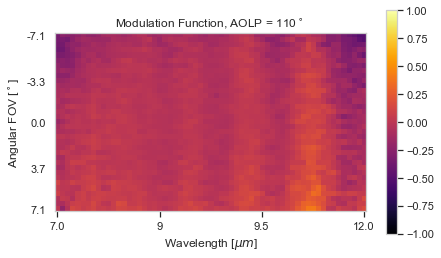

In [92]:

j = 10;
I1 = df['ims1'][j]-B1
I2 = df['ims2'][j]-B2
plt.matshow((I1-I2)/(I1+I2),cmap = 'inferno' )
plt.colorbar()
plt.ylabel('Angular FOV [$^\circ$]')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.yticks([0, 9,17,26,34], [angles[0], angles[9],angles[17],angles[26],angles[34]])
plt.title('Modulation Function, AOLP = ' + str(lps[j])+ '$ ^\circ $ ')
plt.clim([-1,1])
plt.show()


In [32]:
#create sum column
df["totalrad"] = df['ims2']+df['ims1']
df["totalstd"] = (df['s2']**2+df['s1']**2)**0.5

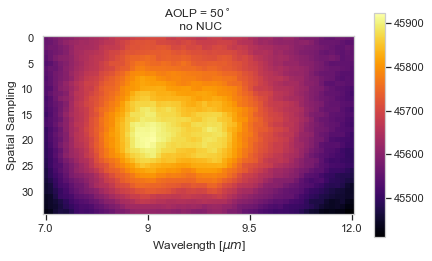

In [36]:
cmin = np.min(list(df['totalrad'])); cmax=np.max(list(df['totalrad']))

j = 5;
plt.matshow(df['totalrad'][j],cmap = 'inferno' )
plt.colorbar()
plt.ylabel('Spatial Sampling')
plt.xlabel('Wavelength [$\mu m$]')
plt.ax = plt.gca()
plt.ax.xaxis.set_ticks_position('bottom')
plt.xticks([0, 20, 40,60], [waves[0],round(waves[20]),waves[30],waves[60]])
plt.title('AOLP = ' + str(lps[j])+ '$^\circ $ \n no NUC')
#plt.clim(cmin,cmax)
plt.show()

In [14]:
# pixel fit 
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x**2 + B

def finv(y,A,B):
    return ((y-B)/A)**0.5


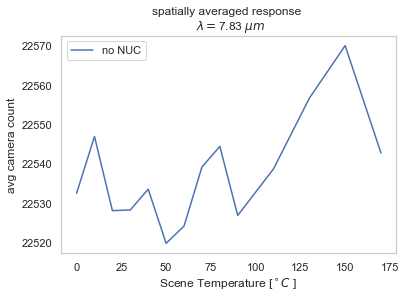

In [30]:
x = 10
y = 30
plt.errorbar(dfn['lps'],get_slice(dfn['ims2'],x,y),label = 'no NUC')
#plt.errorbar(df['lps'],get_slice_avg(df['ims1'],x),yerr=get_slice_avg(df['s1'],x),label = 'no NUC')
plt.title('spatially averaged response \n $\lambda = $' + str(round(waves[x],2)) + ' $  \mu m$')
plt.xlabel('Scene Temperature [$^\circ C$ ] ')
plt.ylabel('avg camera count')
plt.legend()
plt.show()


In [20]:
def get_slice(df,x,y):
    sli = []
    for i in range(len(df)):
        s = df[i]
        sli.append(s[y,x])
    return(sli)

def get_slice_avg(df,x):
    sli = []
    for i in range(len(df)):
        s = df[i]
        sli.append(np.mean(s[:,x]))
    return(sli)